In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import librosa
from noise_reduction import NoiseReducer
from silence_removal import SilenceRemover
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import IPython.display as IPythonAudio

import sys
sys.path.append('..')
from audio import Audio

filtered_metadata_path = os.path.join("..", "data", "filtered_data_labeled.tsv")
audio_dir = os.path.join("..", "data", "filtered_clips")
df = pd.read_csv(filtered_metadata_path, sep="\t")

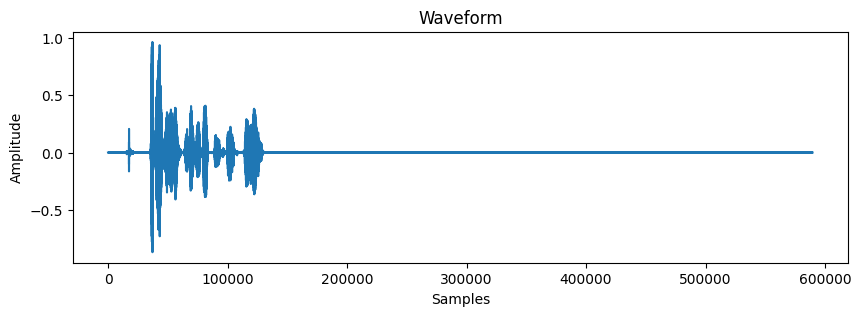

In [12]:
random_sample = df.sample(1).iloc[0]
audio_file = random_sample['path']
audio_file = 'common_voice_en_133993.mp3'  # Replace with the actual file name

audio_file_path = os.path.join(audio_dir, audio_file)
audio, sr = librosa.load(audio_file_path)

plt.figure(figsize=(10, 3))
plt.plot(audio)
plt.title("Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

IPythonAudio.display(IPythonAudio.Audio(audio, rate=sr))

Noise Reduction:   0%|          | 0/1 [00:00<?, ?it/s]

Silence Removal: 100%|██████████| 1/1 [00:00<00:00, 68.80it/s]


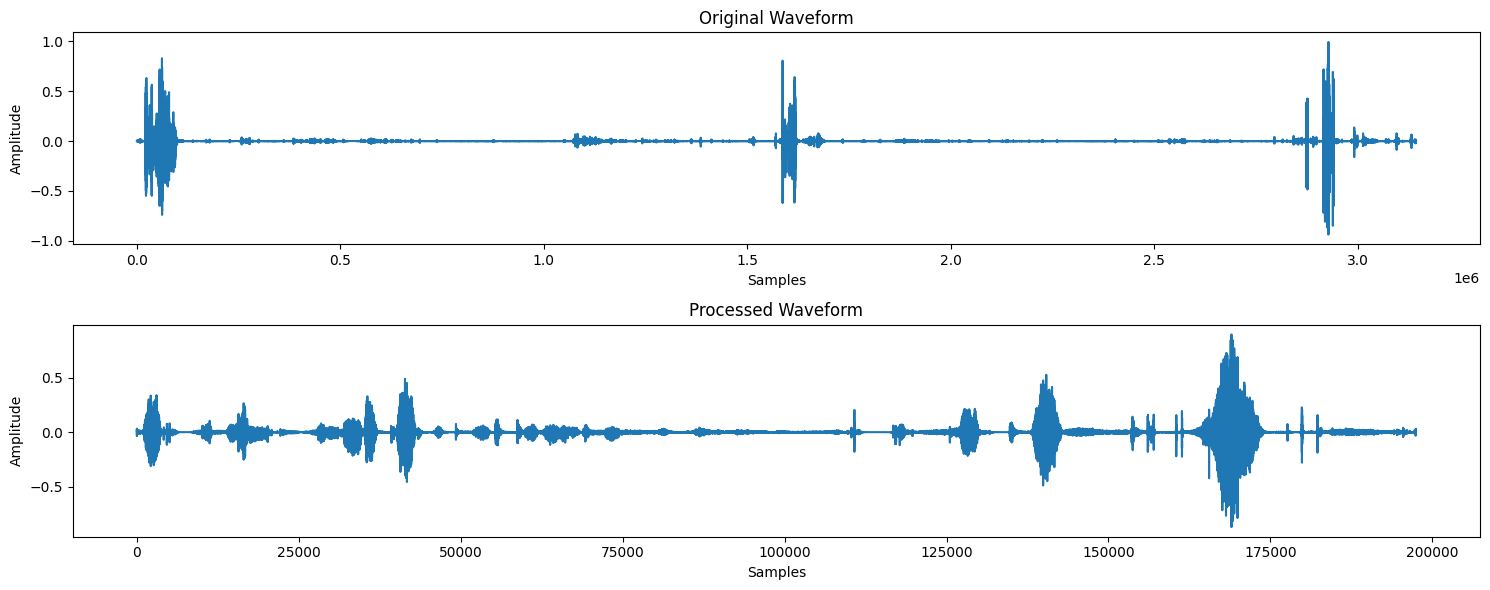

22050


In [3]:
preprocessing_pipeline = Pipeline(steps=[
    ("noise_reduction", NoiseReducer()),
    ("silence_removal", SilenceRemover()),
])

processed_audio = preprocessing_pipeline.fit_transform([Audio(audio, sr)])
plt.figure(figsize=(15, 6))

# Plot original waveform
plt.subplot(2, 1, 1)
plt.plot(audio)
plt.title("Original Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot processed waveform
plt.subplot(2, 1, 2)
plt.plot(processed_audio[0])
plt.title("Processed Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

print(sr)
IPythonAudio.display(IPythonAudio.Audio(processed_audio[0], rate=sr))

Original Duration: 26.736 seconds
Trimmed Duration: 4.4926458333333334 seconds


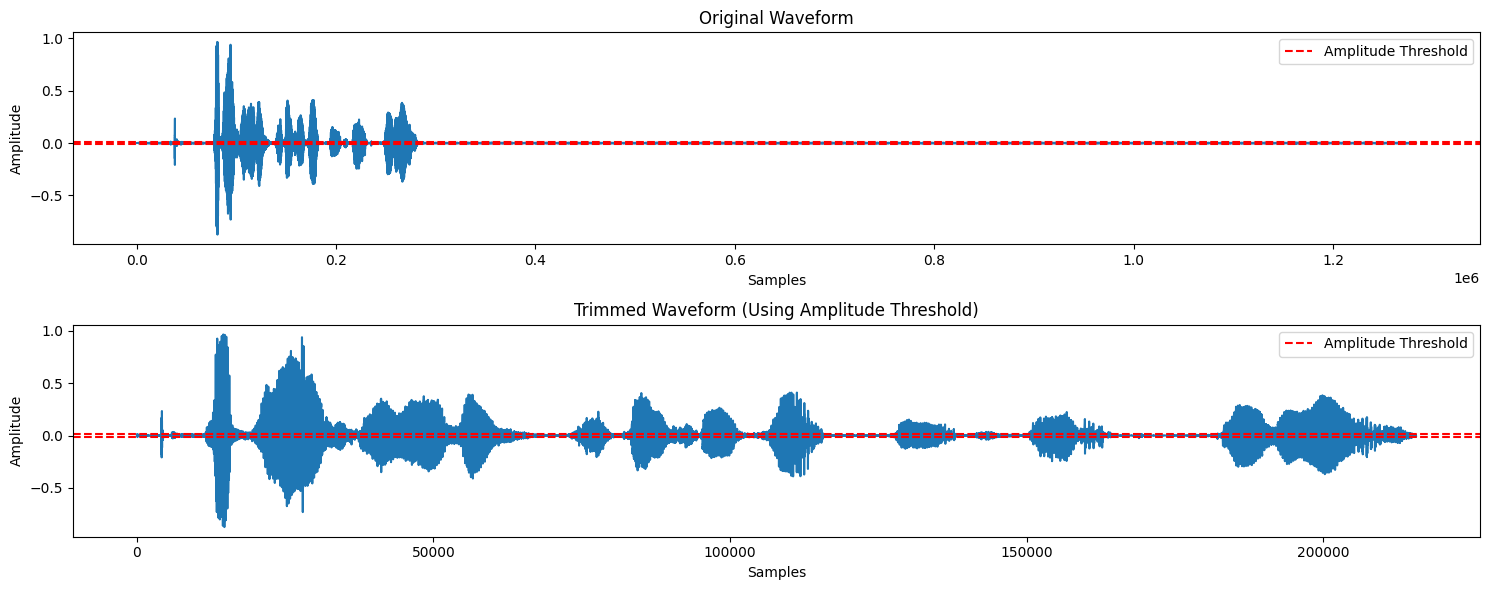

In [14]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as IPAudio

# Load the audio file (replace with your own file)
audio, sr = librosa.load(audio_file_path, sr=None)

# Define an amplitude threshold (this value may need to be adjusted depending on your audio)
amplitude_threshold = 0.01  # You can tweak this value depending on your requirements

# Find indices where the audio is above the amplitude threshold
non_silent = np.abs(audio) > amplitude_threshold
non_silent_indices = np.nonzero(non_silent)[0]

# If there are no non-silent parts, return an empty array with a warning
if len(non_silent_indices) == 0:
  print("Warning: No audio above threshold found.")
  trimmed_audio = np.array([])
else:
  # Identify continuous regions of sound
  regions = []
  region_start = non_silent_indices[0]
  prev_idx = non_silent_indices[0]
  
  # Define gap tolerance (in samples) - adjust as needed
  gap_tolerance = int(0.5 * sr)  # 200ms gap tolerance
  
  for idx in non_silent_indices[1:]:
    # If the gap is too large, end the current region and start a new one
    if idx - prev_idx > gap_tolerance:
      regions.append((region_start, prev_idx))
      region_start = idx
    prev_idx = idx
  
  # Add the last region
  regions.append((region_start, non_silent_indices[-1]))
  
  # Concatenate all non-silent regions
  trimmed_audio = np.concatenate([audio[start:end+1] for start, end in regions])

# Print the duration before and after trimming
original_duration = len(audio) / sr
trimmed_duration = len(trimmed_audio) / sr

print(f"Original Duration: {original_duration} seconds")
print(f"Trimmed Duration: {trimmed_duration} seconds")

# Visualize the original and trimmed audio waveforms
plt.figure(figsize=(15, 6))

# Plot original waveform
plt.subplot(2, 1, 1)
plt.plot(audio)
plt.title("Original Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Add a horizontal line to represent the amplitude threshold
plt.axhline(y=amplitude_threshold, color='r', linestyle='--', label='Amplitude Threshold')
plt.axhline(y=-amplitude_threshold, color='r', linestyle='--')
plt.legend()

# Plot trimmed waveform
plt.subplot(2, 1, 2)
plt.plot(trimmed_audio)
plt.title("Trimmed Waveform (Using Amplitude Threshold)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Add the same threshold line on the trimmed waveform
plt.axhline(y=amplitude_threshold, color='r', linestyle='--', label='Amplitude Threshold')
plt.axhline(y=-amplitude_threshold, color='r', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

# Play the trimmed audio (after silence removal)
IPythonAudio.display(IPythonAudio.Audio(trimmed_audio, rate=sr))


In [15]:
import librosa
import numpy as np

def amplitude_based_silence_removal(y, sr, threshold=0.05, frame_length=2048, hop_length=512):
    # Split into frames
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    frame_amplitudes = np.mean(np.abs(frames), axis=0)
    
    # Identify non-silent frames (boolean mask)
    non_silent = frame_amplitudes > (threshold * np.max(frame_amplitudes))
    
    # Convert frame indices to sample indices
    non_silent_indices = np.where(non_silent)[0]
    
    # Merge contiguous non-silent frames
    ranges = []
    start = None
    for idx in non_silent_indices:
        sample_start = idx * hop_length
        sample_end = sample_start + frame_length
        if start is None:
            start = sample_start
            current_end = sample_end
        else:
            if sample_start <= current_end:
                current_end = sample_end
            else:
                ranges.append((start, current_end))
                start = sample_start
                current_end = sample_end
    if start is not None:
        ranges.append((start, current_end))
    
    # Extract trimmed audio
    y_trimmed = np.concatenate([y[start:end] for (start, end) in ranges])
    
    return y_trimmed

trimmed_islam = amplitude_based_silence_removal(audio, sr, threshold=0.005, frame_length=sr//2, hop_length=512)

IPythonAudio.display(IPythonAudio.Audio(trimmed_islam, rate=sr))